In [1]:
#...... general imports

import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from tqdm import tqdm

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist # custom object

#...... new MCMC imports
import corner
import emcee
from chainconsumer import ChainConsumer

#...... plot formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = (0.0, 0.0, 0.0, 0.0)


#...... colors 

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF996 6", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

### shmf data structures

In [2]:
h = 0.7 #H0 in units of 100 km/s/Mpc
m_part = 3e5 #particle mass, Msun/h

#...... particle limits?
lower_limit=300 
upper_limit=1.3e4 # why do we set this uppper limit here?

bin_number=10
base_mpeak = np.logspace(np.log10(m_part/h*lower_limit),np.log10(m_part/h*upper_limit),bin_number)

def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

In [3]:
halo_id = 'Halo004'

#...... high level setup, model and redshift lists.
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
redshifts = np.linspace(0, 4.5, 50)

#...... data storage setup (general)

cdm_shmf_mpeak = {}
wdm_shmf_mpeak = {}

wdm_shmf_mpeak_suppression = {}
wdm_shmf_mpeak_suppression_err = {}

#...... cold dark matter, constant model
cdm = hlist(halo_id=halo_id, model='cdm')
cdm.load_hlists()
cdm.load_hmb()


#..... cycles through all models
for model in models:
    
    #...... warm dark matter, variable mass
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    cdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak_suppression[model] = {}
    wdm_shmf_mpeak_suppression_err[model] = {}
    
    #...... cycles through redshifts up to z = 4.5
    for z in tqdm(redshifts):

        #...... data storage setup (based on redshift)

        cdm_shmf_mpeak[model][f'{z}'] = {}
        cdm_shmf_mpeak[model][f'{z}']['phi'] = []
        cdm_shmf_mpeak[model][f'{z}']['N'] = []

        wdm_shmf_mpeak[model][f'{z}'] = {}
        wdm_shmf_mpeak[model][f'{z}']['phi'] = []
        wdm_shmf_mpeak[model][f'{z}']['N'] = []

        # getting halos for given redshift
        halos, subhalos = cdm.get_z(z)
        halos_wdm, subhalos_wdm = wdm.get_z(z)

        # distances of isolated halo pop from host halo
        distances = np.sqrt((halos['x']-cdm.hmb['x'][0])**2+(halos['y']-cdm.hmb['y'][0])**2+(halos['z']-cdm.hmb['z'][0])**2)
        
        # mass and distance cut; 900e5 Msun/h, 3 Mpc
        ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)

        # getting shmf
        cdm_temp = get_shmf(halos['Mpeak'][ind_cdm]/h,base_mpeak)
        cdm_shmf_mpeak[model][f'{z}']['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
        cdm_shmf_mpeak[model][f'{z}']['N'].append(cdm_temp[1]) # shmf, values

        #...... same process, warm dark matter
        distances = np.sqrt((halos_wdm['x']-wdm.hmb['x'][0])**2+(halos_wdm['y']-wdm.hmb['y'][0])**2+(halos_wdm['z']-wdm.hmb['z'][0])**2)
        ind = (halos_wdm['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
        wdm_temp = get_shmf(halos_wdm['Mpeak'][ind]/h,base_mpeak)
        wdm_shmf_mpeak[model][f'{z}']['phi'].append(wdm_temp[0])
        wdm_shmf_mpeak[model][f'{z}']['N'].append(wdm_temp[1])

        # poisson error on the mean; when combining different realizations, 

        yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)

        #...... saving suppresion and error

        wdm_shmf_mpeak_suppression[model][f'{z}'] = np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        wdm_shmf_mpeak_suppression_err[model][f'{z}'] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)


100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


### existing functions (week 4)

In [4]:
def transfer(k, mwdm, a = 0.0292, b = -1.188, nu = 1.049, theta = 2.012, eta = 0.2463, omega_m=0.286, h=0.7):
    alpha = a*(mwdm**b)*((omega_m*h*h/0.12)**eta)*((h/0.6736)**theta)
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

def khm(mwdm, k_array=np.logspace(0,3,1000), h=0.7):
    return k_array[np.argmin(np.abs(transfer(k_array,mwdm)**2-0.25))]*h

def Mhm(mwdm, omega_m = 0.286, h=0.7):
    rho_m = 1.36*10**11*omega_m
    return (4.*np.pi*rho_m/3.)*((2.*np.pi/(khm(mwdm)*h))/2.)**3.

def shmf_suppression(M,mwdm,alpha=2.7,beta=1.,gamma=0.99):
    return (1.+(alpha*(Mhm(mwdm))/(M))**beta)**(-1.*gamma)

In [5]:
def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, model='wdm_3', z = 0.0):
    alpha, beta, gamma = theta
    lnlike = 0.
    mass = float(model[4:]) 
    
    shmf_model = (1.+(alpha*Mhm(mass)/x)**beta)**(-1.*gamma)
    lnlike += -0.5*np.sum((y[model][f'{z}']-shmf_model)**2/yerr[model][f'{z}']**2 + np.log(yerr[model][f'{z}']**2))
    return lnlike

def log_prior(theta):
    alpha, beta, gamma = theta
    if 0. < gamma < 5. and 0. < alpha < 50. and 0. < beta < 10.:
        return np.log(1.0/(1.0+(beta**2))) + np.log(1.0/(1.0+(gamma**2)))
    return -np.inf

def log_probability(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, model='wdm_3', z = 0.0):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model, z)

In [50]:
z_desired = 0
redshifts = np.linspace(0, 4.5, 50)


x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = wdm_shmf_mpeak_suppression
yerr = wdm_shmf_mpeak_suppression_err
model = 'wdm_3'
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, model, z))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [03:12<00:00, 52.06it/s]


best fit values:
[2.65356038 0.44037257 0.89081321]


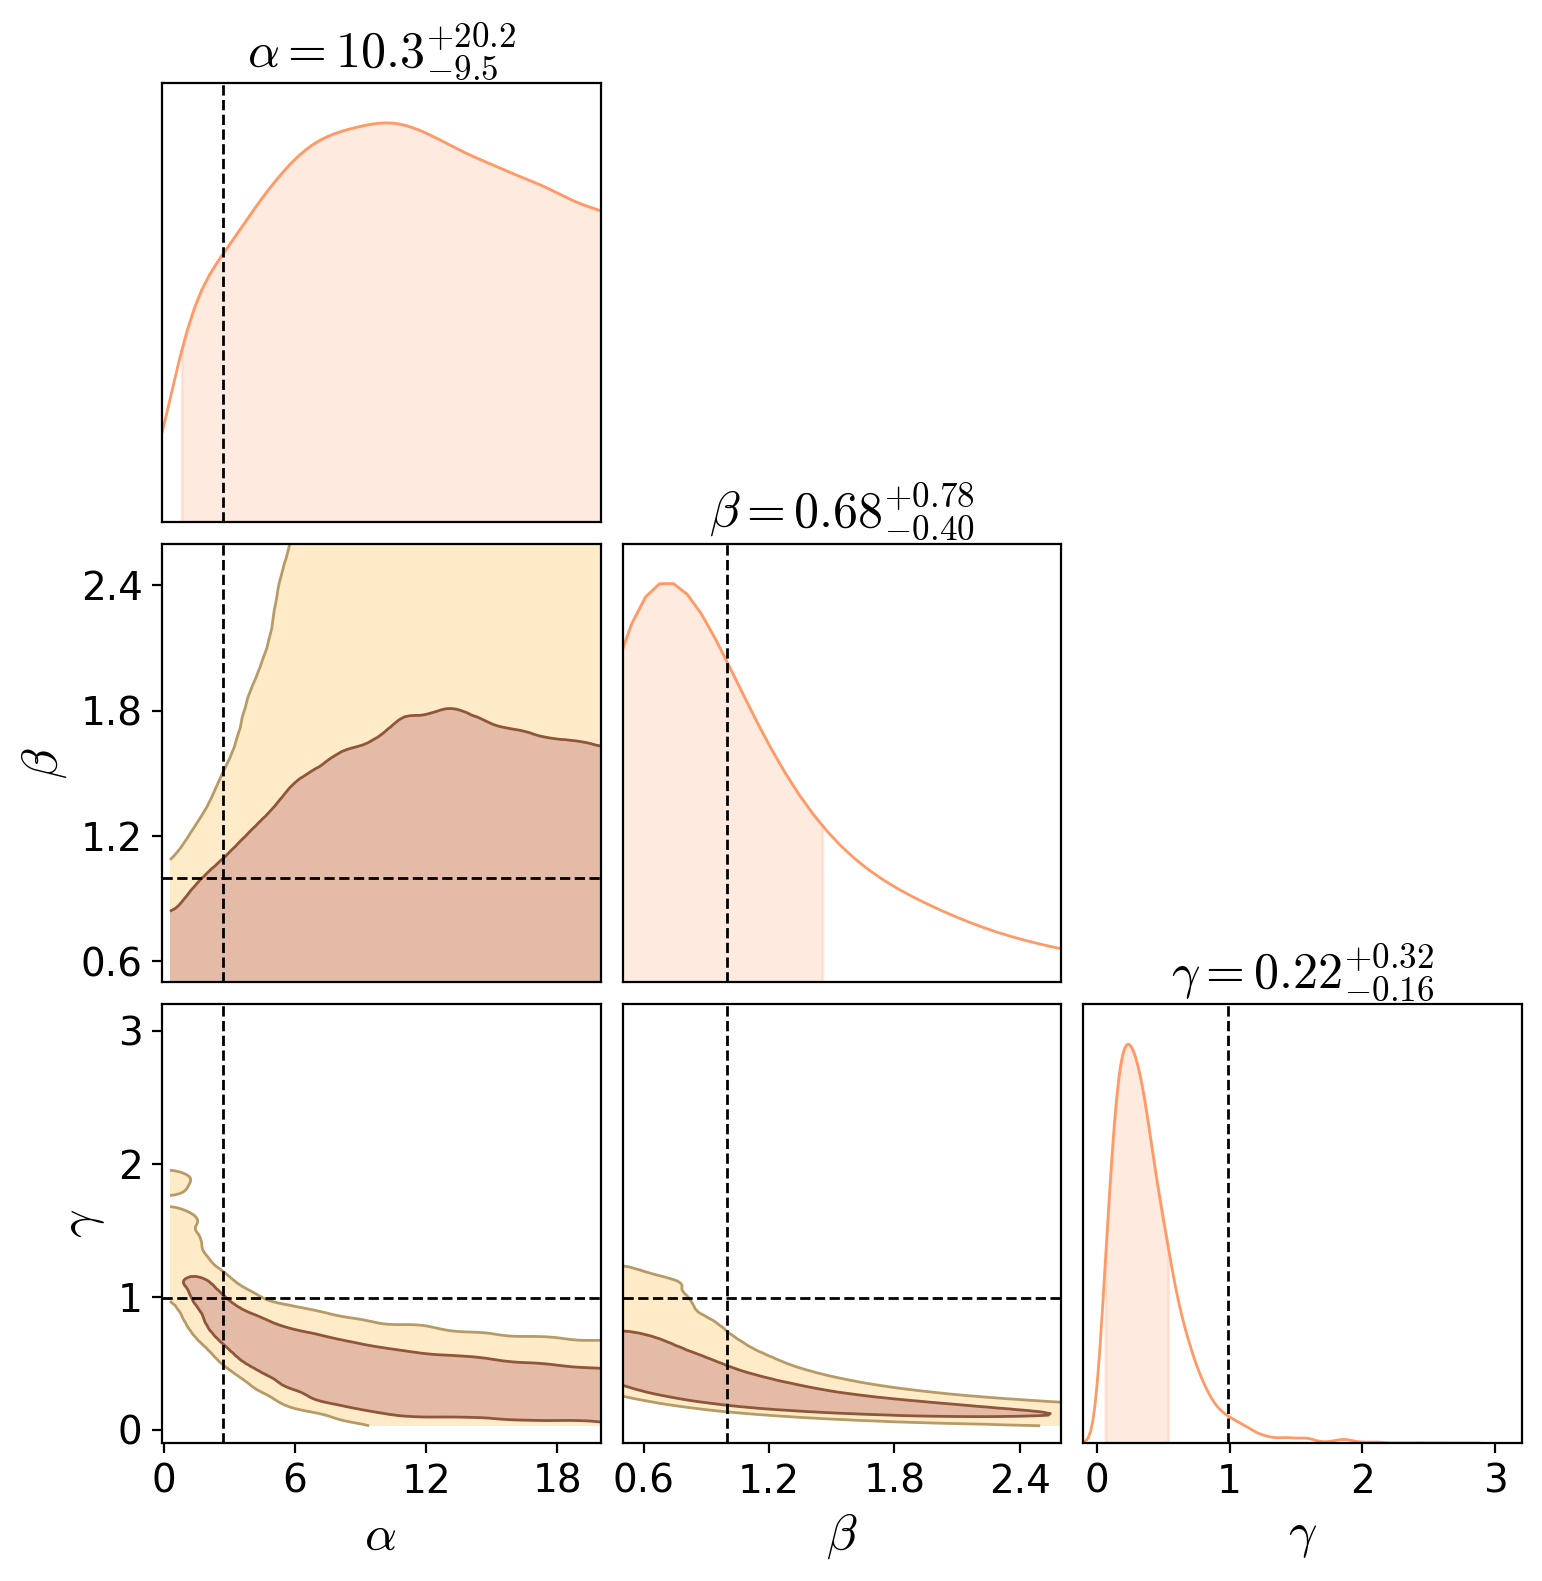

In [51]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

c.configure(colors=[sim_colors['wdm_4'], sim_colors['wdm_5']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

### combined realizations

In [92]:
z_desired = 3

redshifts = np.linspace(0, 4.5, 50)
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
# models = ['wdm_3', 'wdm_5','wdm_6.5']

combined_model = []
combined_model_err = []

for model in models:
    
    combined_model.append(wdm_shmf_mpeak_suppression[model][f'{z}'])
    combined_model_err.append(wdm_shmf_mpeak_suppression_err[model][f'{z}'])
    
    
combined_model = np.asarray(combined_model)
combined_model_err = np.asarray(combined_model_err)

In [93]:


def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    alpha, beta, gamma = theta
    lnlike = 0.
    
    shmf_model = []
    for model in models:
        shmf_model.append((1.+(alpha*Mhm(float(model[4:]))/x)**beta)**(-1.*gamma))
    shmf_model = np.asarray(shmf_model) 
    
    lnlike += -0.5*np.sum((y-shmf_model)**2/yerr**2 + np.log(yerr**2))
    return lnlike

def log_probability(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, z)

In [94]:
x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = combined_model
yerr = combined_model_err
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, z))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [23:07<00:00,  7.21it/s]


best fit values:
[2.51173031 1.14491757 0.66109   ]


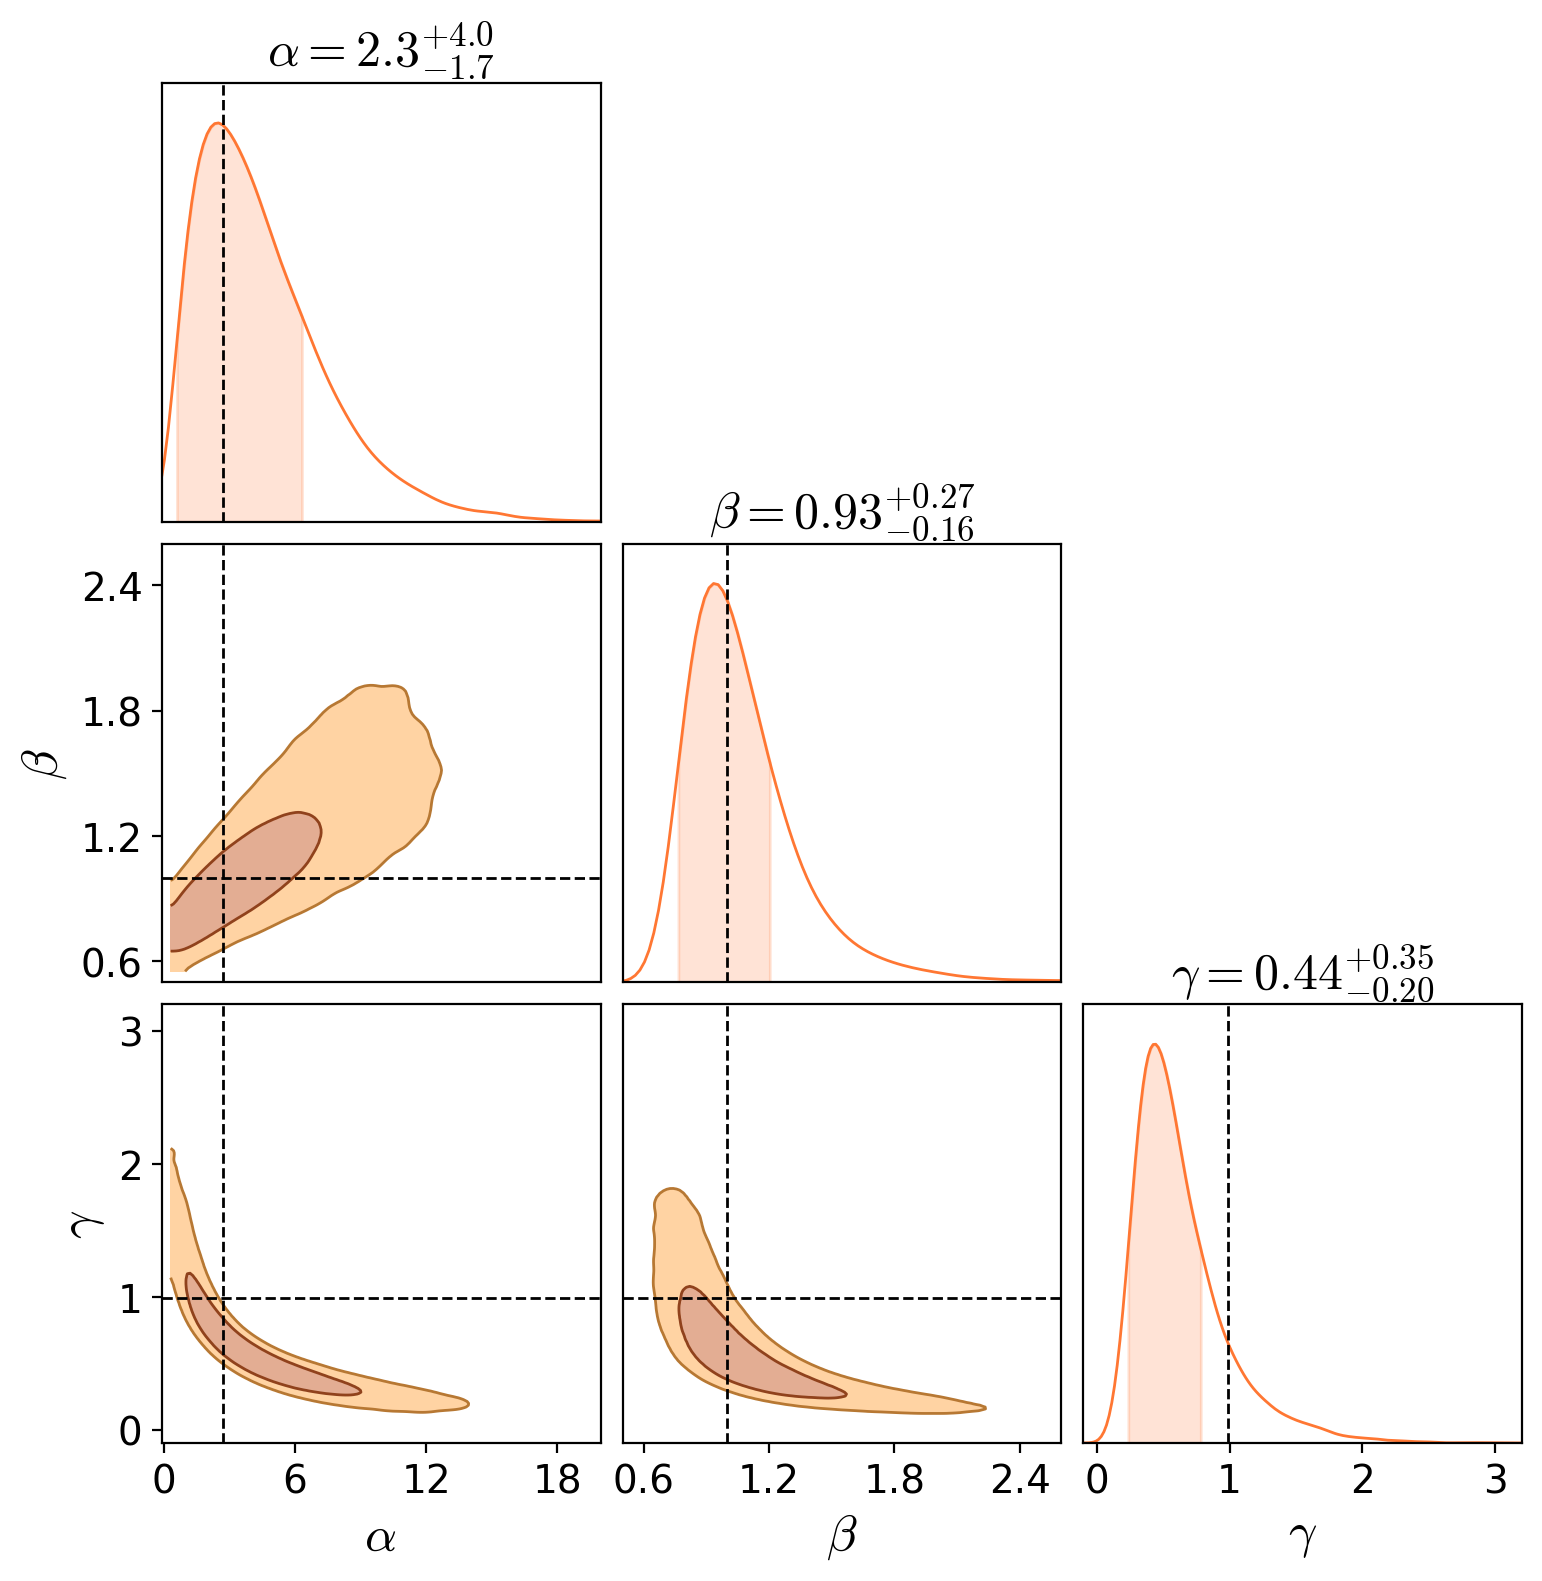

In [95]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

c.configure(colors=[sim_colors['wdm_5'], sim_colors['wdm_6']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

#### plots SHMF suppression for MCMC best fit values

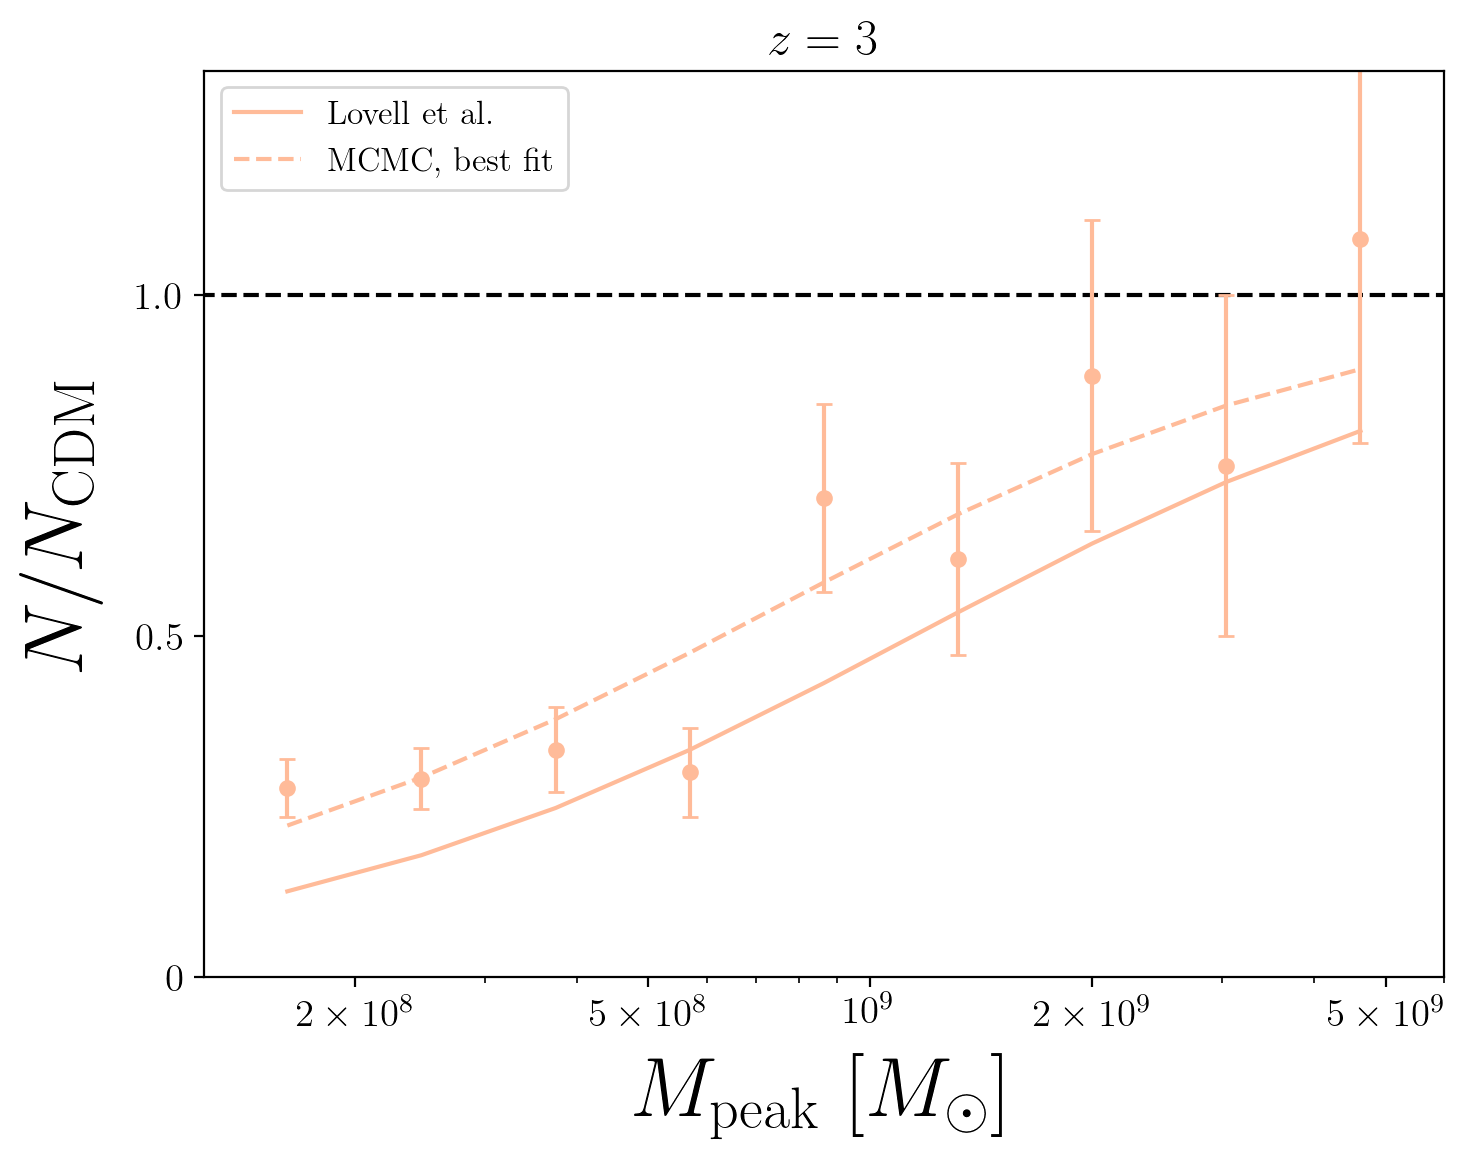

In [98]:


plt.figure(figsize=(8,6))
plt.xscale('log')

###
models = ['wdm_3'] #'wdm_5', 'wdm_6.5']
M = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
params = flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)]
plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k')


for model in models:
    
    plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]), wdm_shmf_mpeak_suppression[model][z],
                marker='o',color=sim_colors[model],s=10)

    plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_mpeak_suppression[model][z],yerr=wdm_shmf_mpeak_suppression_err[model][z],
                 linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])
    
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]), shmf_suppression(M, float(model[4:])),
                c=sim_colors[model], label=f'Lovell et al.', linestyle='-')
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]), shmf_suppression(M, float(model[4:]), *params),
                c=sim_colors[model], label=f'MCMC, best fit', linestyle='--')

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

plt.legend(fontsize=12)
plt.title(f'$z = {z_desired}$', fontsize=18)

plt.show()

### full combination (realization and model)

ignoring error, that seems to be incorrect for Halo 023 (see shmf_suppression notebook); needs to be fixed at a later date

In [6]:
#...... high level setup, model and redshift lists.
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
realizations = ['Halo004', 'Halo113']
redshifts = np.linspace(0, 4.5, 50)

#...... data storage setup (general)

cdm_shmf_combined = {}
wdm_shmf_combined = {}

wdm_shmf_combined_suppression = {}
wdm_shmf_combined_suppression_err = {}


#..... cycles through all models
for model in models:
    
    cdm_shmf_combined[model] = {}
    wdm_shmf_combined[model] = {}
    wdm_shmf_combined_suppression[model] = {}
    wdm_shmf_combined_suppression_err[model] = {}
    
    for halo_id in realizations:
        
        print(model, halo_id)
        
        #...... cold dark matter, constant model
        cdm = hlist(halo_id=halo_id, model='cdm')
        cdm.load_hlists()
        cdm.load_hmb()
    
        #...... warm dark matter, variable mass
        wdm = hlist(halo_id=halo_id, model=model)
        wdm.load_hlists()
        wdm.load_hmb()

        cdm_shmf_combined[model][halo_id] = {}
        wdm_shmf_combined[model][halo_id] = {}
        wdm_shmf_combined_suppression[model][halo_id] = {}
        wdm_shmf_combined_suppression_err[model][halo_id] = {}

        #...... cycles through redshifts up to z = 4.5
        for z in tqdm(redshifts):

            #...... data storage setup (based on redshift)

            cdm_shmf_combined[model][halo_id][f'{z}'] = {}
            cdm_shmf_combined[model][halo_id][f'{z}']['phi'] = []
            cdm_shmf_combined[model][halo_id][f'{z}']['N'] = []

            wdm_shmf_combined[model][halo_id][f'{z}'] = {}
            wdm_shmf_combined[model][halo_id][f'{z}']['phi'] = []
            wdm_shmf_combined[model][halo_id][f'{z}']['N'] = []

            # getting halos for given redshift
            halos, subhalos = cdm.get_z(z)
            halos_wdm, subhalos_wdm = wdm.get_z(z)

            # distances of isolated halo pop from host halo
            distances = np.sqrt((halos['x']-cdm.hmb['x'][0])**2+(halos['y']-cdm.hmb['y'][0])**2+(halos['z']-cdm.hmb['z'][0])**2)

            # mass and distance cut; 900e5 Msun/h, 3 Mpc
            ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)

            # getting shmf
            cdm_temp = get_shmf(halos['Mpeak'][ind_cdm]/h,base_mpeak)
            cdm_shmf_combined[model][halo_id][f'{z}']['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
            cdm_shmf_combined[model][halo_id][f'{z}']['N'].append(cdm_temp[1]) # shmf, values

            #...... same process, warm dark matter
            distances = np.sqrt((halos_wdm['x']-wdm.hmb['x'][0])**2+(halos_wdm['y']-wdm.hmb['y'][0])**2+(halos_wdm['z']-wdm.hmb['z'][0])**2)
            ind = (halos_wdm['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
            wdm_temp = get_shmf(halos_wdm['Mpeak'][ind]/h,base_mpeak)
            wdm_shmf_combined[model][halo_id][f'{z}']['phi'].append(wdm_temp[0])
            wdm_shmf_combined[model][halo_id][f'{z}']['N'].append(wdm_temp[1])
            
            # poisson error on the mean; when combining different realizations, 

            yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf_combined[model][halo_id][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)
            yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf_combined[model][halo_id][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)

            #...... saving suppresion and error

            wdm_shmf_combined_suppression[model][halo_id][f'{z}'] = np.mean(wdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_combined[model][halo_id][f'{z}']['phi'],axis=0)
            wdm_shmf_combined_suppression_err[model][halo_id][f'{z}'] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)


wdm_3 Halo004


100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


wdm_3 Halo113


100%|██████████| 50/50 [02:33<00:00,  3.08s/it]


wdm_4 Halo004


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


wdm_4 Halo113


100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


wdm_5 Halo004


100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


wdm_5 Halo113


100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


wdm_6 Halo004


100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


wdm_6 Halo113


100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


wdm_6.5 Halo004


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


wdm_6.5 Halo113


100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


wdm_10 Halo004


100%|██████████| 50/50 [02:03<00:00,  2.48s/it]


wdm_10 Halo113


100%|██████████| 50/50 [03:25<00:00,  4.11s/it]


In [7]:
z_desired = 0

redshifts = np.linspace(0, 4.5, 50)
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
# models = ['wdm_3', 'wdm_5','wdm_6.5']

combined_model = []
combined_model_err = []

for model in models:
    
    combined_model.append(wdm_shmf_combined_suppression[model]['Halo004'][f'{z}'])
    combined_model.append(wdm_shmf_combined_suppression[model]['Halo113'][f'{z}'])
    combined_model_err.append(wdm_shmf_combined_suppression_err[model]['Halo004'][f'{z}'])
    combined_model_err.append(wdm_shmf_combined_suppression_err[model]['Halo113'][f'{z}'])
    
    
combined_model = np.asarray(combined_model)
combined_model_err = np.asarray(combined_model_err)

In [8]:
def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    alpha, beta, gamma = theta
    lnlike = 0.
    
    shmf_model = []
    for model in models:
        shmf_model.append((1.+(alpha*Mhm(float(model[4:]))/x)**beta)**(-1.*gamma))
        shmf_model.append((1.+(alpha*Mhm(float(model[4:]))/x)**beta)**(-1.*gamma))
    shmf_model = np.asarray(shmf_model) 
    
    lnlike += -0.5*np.sum((y-shmf_model)**2/yerr**2 + np.log(yerr**2))
    return lnlike

def log_prior(theta):
    alpha, beta, gamma = theta
    if 0. < gamma < 5. and 0. < alpha < 50. and 0. < beta < 10.:
        return np.log(1.0/(1.0+(beta**2))) + np.log(1.0/(1.0+(gamma**2)))
    return -np.inf

def log_probability(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, z)

In [9]:
x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = combined_model
yerr = combined_model_err
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, z))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [42:30<00:00,  3.92it/s]


In [10]:
z_desired = 4

redshifts = np.linspace(0, 4.5, 50)
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
# models = ['wdm_3', 'wdm_5','wdm_6.5']

combined_model = []
combined_model_err = []

for model in models:
    
    combined_model.append(wdm_shmf_combined_suppression[model]['Halo004'][f'{z}'])
    combined_model.append(wdm_shmf_combined_suppression[model]['Halo113'][f'{z}'])
    combined_model_err.append(wdm_shmf_combined_suppression_err[model]['Halo004'][f'{z}'])
    combined_model_err.append(wdm_shmf_combined_suppression_err[model]['Halo113'][f'{z}'])
    
    
combined_model = np.asarray(combined_model)
combined_model_err = np.asarray(combined_model_err)

x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = combined_model
yerr = combined_model_err
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler_highz = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, z))
sampler_highz.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [42:23<00:00,  3.93it/s]


best fit values:
[1.6151349  0.74372307 1.19311144]


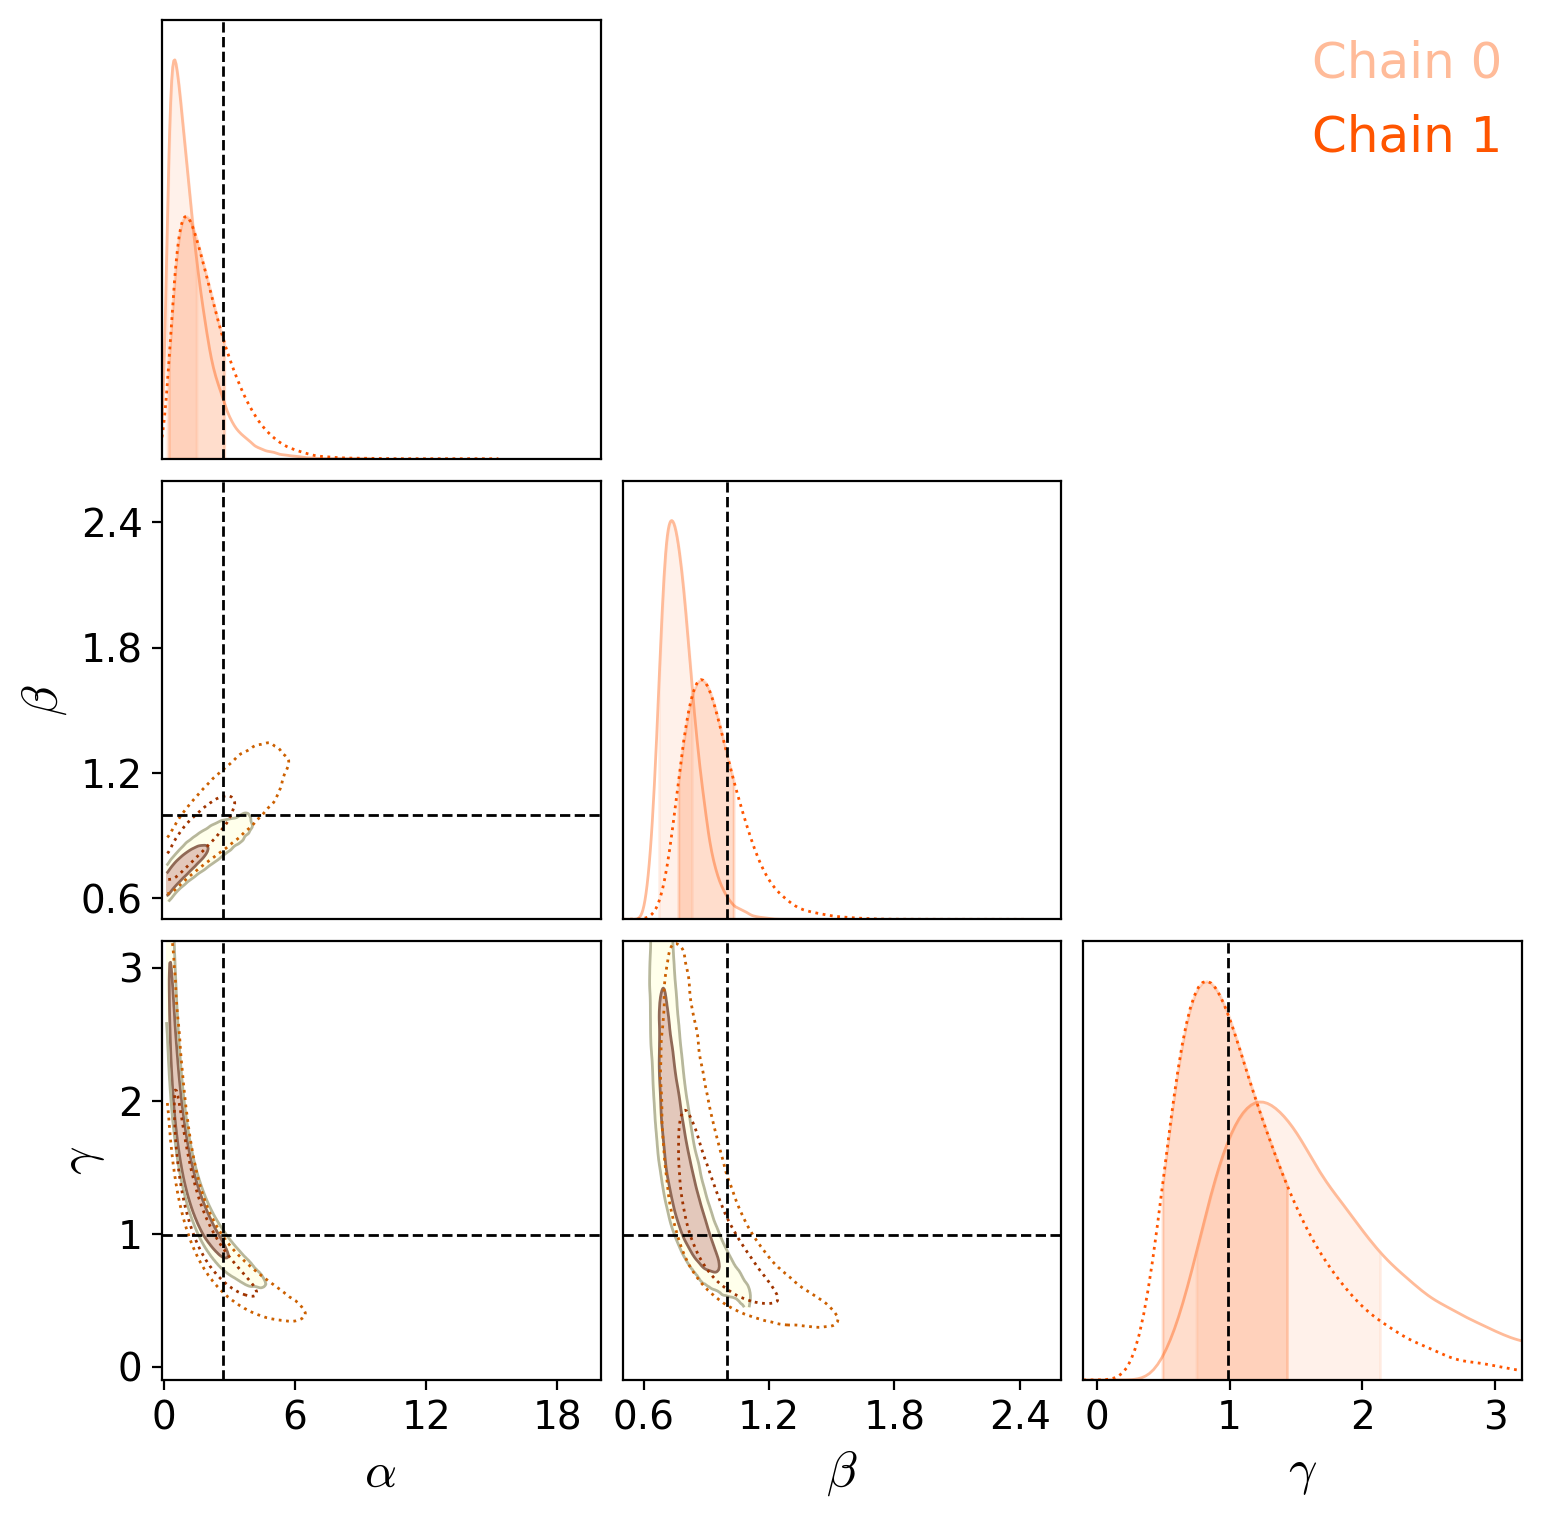

In [18]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
flat_samples_highz = sampler_highz.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"], linestyle='-')
c.add_chain(flat_samples_highz, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"], linestyle=':')

c.configure(colors=[sim_colors['wdm_3'], sim_colors['wdm_6']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

# Halo023 debug

In [13]:
halo_id = 'Halo023'

#...... high level setup, model and redshift lists.
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
redshifts = np.linspace(0, 4.5, 50)

#...... data storage setup (general)

cdm_shmf_mpeak = {}
wdm_shmf_mpeak = {}

wdm_shmf_mpeak_suppression = {}
wdm_shmf_mpeak_suppression_err = {}

#...... cold dark matter, constant model
cdm = hlist(halo_id=halo_id, model='cdm')
cdm.load_hlists()
cdm.load_hmb()


#..... cycles through all models
for model in models:
    
    #...... warm dark matter, variable mass
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    cdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak_suppression[model] = {}
    wdm_shmf_mpeak_suppression_err[model] = {}
    
    #...... cycles through redshifts up to z = 4.5
    for z in tqdm(redshifts):

        #...... data storage setup (based on redshift)

        cdm_shmf_mpeak[model][f'{z}'] = {}
        cdm_shmf_mpeak[model][f'{z}']['phi'] = []
        cdm_shmf_mpeak[model][f'{z}']['N'] = []

        wdm_shmf_mpeak[model][f'{z}'] = {}
        wdm_shmf_mpeak[model][f'{z}']['phi'] = []
        wdm_shmf_mpeak[model][f'{z}']['N'] = []

        # getting halos for given redshift
        halos, subhalos = cdm.get_z(z)
        halos_wdm, subhalos_wdm = wdm.get_z(z)

        # distances of isolated halo pop from host halo
        distances = np.sqrt((halos['x']-cdm.hmb['x'][0])**2+(halos['y']-cdm.hmb['y'][0])**2+(halos['z']-cdm.hmb['z'][0])**2)
        
        # mass and distance cut; 900e5 Msun/h, 3 Mpc
        ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)

        # getting shmf
        cdm_temp = get_shmf(halos['Mpeak'][ind_cdm]/h,base_mpeak)
        cdm_shmf_mpeak[model][f'{z}']['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
        cdm_shmf_mpeak[model][f'{z}']['N'].append(cdm_temp[1]) # shmf, values

        #...... same process, warm dark matter
        distances = np.sqrt((halos_wdm['x']-wdm.hmb['x'][0])**2+(halos_wdm['y']-wdm.hmb['y'][0])**2+(halos_wdm['z']-wdm.hmb['z'][0])**2)
        ind = (halos_wdm['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
        wdm_temp = get_shmf(halos_wdm['Mpeak'][ind]/h,base_mpeak)
        wdm_shmf_mpeak[model][f'{z}']['phi'].append(wdm_temp[0])
        wdm_shmf_mpeak[model][f'{z}']['N'].append(wdm_temp[1])

        # poisson error on the mean; when combining different realizations, 
        
        try: 
            yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
            yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)

        except RuntimeWarning:
            yerr = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
            yerr = np.nan_to_num(yerr, copy=True, nan=0.0, posinf=0.0)
            yerr_lower, yerr_upper = yerr
            
        #...... saving suppresion and error

        try:
            wdm_shmf_mpeak_suppression[model][f'{z}'] = np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)

        except RuntimeWarning:
            temp = np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
            wdm_shmf_mpeak_suppression[model][f'{z}'] = np.nan_to_num(temp, copy=True, nan=0.0, posinf=0.0)
        
        wdm_shmf_mpeak_suppression_err[model][f'{z}'] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)

 44%|████▍     | 22/50 [00:44<01:01,  2.19s/it]/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


In [1]:
z_desired = 4.5
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])

plt.figure(figsize=(8,6))
plt.xscale('log')

###
models = ['wdm_5'] #'wdm_5', 'wdm_6.5']
M = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
# params = flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)]
plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k')


for model in models:
    
    plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]), wdm_shmf_mpeak_suppression[model][z],
                marker='o',color=sim_colors[model],s=10)

    plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_mpeak_suppression[model][z],yerr=wdm_shmf_mpeak_suppression_err[model][z],
                 linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])
    
    
#     plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]), shmf_suppression(M, float(model[4:])),
#                 c=sim_colors[model], label=f'Lovell et al.', linestyle='-')
    
#     plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]), shmf_suppression(M, float(model[4:]), *params),
#                 c=sim_colors[model], label=f'MCMC, best fit', linestyle='--')

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

plt.legend(fontsize=12)
plt.title(f'$z = {z_desired}$', fontsize=18)

plt.show()

NameError: name 'redshifts' is not defined

In [35]:
a = wdm_shmf_mpeak_suppression['wdm_3'][z]
np.nan_to_num(a, copy=True, nan=0.0, posinf=0.0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
cdm_shmf_mpeak['wdm_3'][z]

{'phi': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.84260372e-09, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00])], 'N': [array([0, 0, 0, 0, 0, 1, 0, 0, 0])]}

In [37]:
wdm_shmf_mpeak['wdm_3'][z]

{'phi': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.80092233e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00])], 'N': [array([0, 0, 0, 0, 1, 0, 0, 0, 0])]}

In [44]:
wdm = hlist(model='wdm_3', halo_id=halo_id)
wdm.load_hmb()
wdm.load_hlists()
halos, subhalos = wdm.get_z(4.5)

In [47]:
distances = np.sqrt((halos['x']-wdm.hmb['x'][0])**2+(halos['y']-wdm.hmb['y'][0])**2+(halos['z']-wdm.hmb['z'][0])**2)
ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
m = halos['Mpeak'][ind_cdm]

In [48]:
def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

In [49]:
get_shmf(m, base_mpeak)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.80092233e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([1.28571429e+08, 1.95440062e+08, 2.97086360e+08, 4.51597818e+08,
        6.86469043e+08, 1.04349430e+09, 1.58620459e+09, 2.41117273e+09,
        3.66519804e+09, 5.57142857e+09]))

In [50]:
m

array([7.25e+08], dtype=float32)